In [39]:
import autograd.numpy as np
import autograd.numpy.random as npr
import scipy.io
npr.seed(0)

import ssm
from ssm.util import find_permutation, split_by_trials
from ssm.plots import gradient_cmap, white_to_color_cmap

import matplotlib.pyplot as plt
%matplotlib inline

# import seaborn as sns
# sns.set_style("white")
# sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

# colors = sns.xkcd_palette(color_names)
# cmap = gradient_cmap(colors)


# Speficy whether or not to save figures
save_figures = True

%reload_ext autoreload
%autoreload 2

In [2]:
# Set the parameters of the HMM
time_bins = 300   # number of time bins
num_states = 3    # number of discrete states
obs_dim = 10       # dimensionality of observation

# Make an HMM
true_hmm = ssm.HMM(num_states, obs_dim, observations="block")

true_hmm.observations.mus = np.array([1, 4, 9]).T
true_hmm.observations.sigmas = np.array([0.8, 0.8, 0.8]).T

# Sample some data from the HMM
true_states, obs = true_hmm.sample(time_bins)
# true_ll = true_hmm.log_probability(obs)

arr=  true_hmm.observations.log_likelihoods(obs, None, None, None)

In [37]:
obs

array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False,  True]])

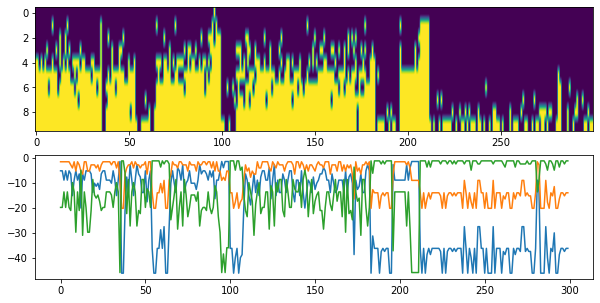

In [15]:
plt.figure(figsize=(10,5))
plt.subplot(211)
plt.imshow(obs.T, aspect='auto')
plt.subplot(212)
plt.plot(arr)

In [55]:
obs.shape

(300, 10)

-1261.1748281187506
Autograd ArrayBox with value -1261.1748281187506
-1231.8861392963167
Autograd ArrayBox with value -1231.8861392963167
-1120.0928207102095
Autograd ArrayBox with value -1120.0928207102095
-10421.003078867736
Autograd ArrayBox with value -10421.003078867736
-1119.639098951066
Autograd ArrayBox with value -1119.639098951066
-1073.2158570989616
Autograd ArrayBox with value -1073.2158570989616
-1069.508706789783
Autograd ArrayBox with value -1069.508706789783
-981.977095719218
Autograd ArrayBox with value -981.977095719218
-880.0371207170762
Autograd ArrayBox with value -880.0371207170762
-789.7658798207075
Autograd ArrayBox with value -789.7658798207075
-788.2298308070526
Autograd ArrayBox with value -788.2298308070526
-776.2520093453586
Autograd ArrayBox with value -776.2520093453586
-765.8152328932294
Autograd ArrayBox with value -765.8152328932294
-761.4339578895726
Autograd ArrayBox with value -761.4339578895726
-760.2393784038553
Autograd ArrayBox with value -760.2

  0%|          | 0/5000 [00:00<?, ?it/s]

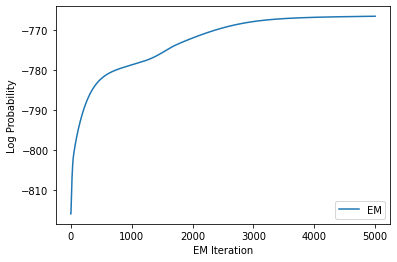

In [53]:
data = obs # Treat observations generated above as synthetic data.
N_iters = 5000

## testing the constrained transitions class
hmm = ssm.HMM(num_states, obs_dim, observations="block")

hmm_lls = hmm.fit(obs, method="sgd", num_iters=N_iters, init_method="kmeans")

plt.plot(hmm_lls, label="EM")
# plt.plot([0, N_iters], true_ll * np.ones(2), ':k', label="True")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")
plt.show()

In [26]:
hmm.observations.params

(array([[0.77318591],
        [4.16693142],
        [9.05517586]]),
 array([[0.41970903],
        [0.89947556],
        [0.81966287]]))

In [27]:
true_hmm.observations.params

(array([1, 4, 9]), array([0.8, 0.8, 0.8]))

In [24]:
find_permutation(np.array([0,1,2,2]), np.array([2,1,1,1]))

array([2, 0, 1])

In [25]:
most_likely_states = hmm.most_likely_states(obs)
hmm.permute(find_permutation(true_states, most_likely_states))

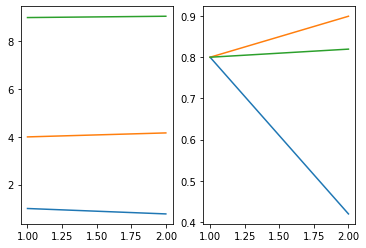

In [32]:
# Comparing the true and inferred parameters
true_mus, true_sigmas = true_hmm.observations.params
sim_mus, sim_sigmas = hmm.observations.params


plt.figure()
plt.subplot(121)
for i in range(3):
    plt.plot([1,2], [true_mus[i], sim_mus[i]])
    
plt.subplot(122)
for i in range(3):
    plt.plot([1,2], [true_sigmas[i], sim_sigmas[i]])

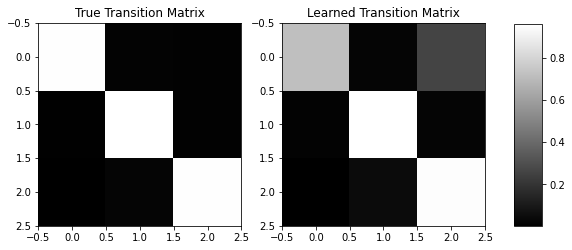

In [33]:
true_transition_mat = true_hmm.transitions.transition_matrix
learned_transition_mat = hmm.transitions.transition_matrix

fig = plt.figure(figsize=(8, 4))
plt.subplot(121)
im = plt.imshow(true_transition_mat, cmap='gray')
plt.title("True Transition Matrix")

plt.subplot(122)
im = plt.imshow(learned_transition_mat, cmap='gray')
plt.title("Learned Transition Matrix")

cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()


## Fit to animal behavior

In [100]:
# Load data
filepath = '/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/'
data = scipy.io.loadmat(filepath + 'expdata/f01_all_sessions.mat')

id = 29
choices = data['choices_cell'][0][id][0]
targets = data['targets_cell'][0][id][0].astype('float')

# flip choices for targets = 0
signedtargets = targets * 2 - 1
signedchoices = (choices * signedtargets + 1) / 2


bpos = np.where(np.diff(targets))
bpos = np.hstack([-1, bpos[0], len(targets) - 1])
blens = np.diff((bpos))
# blens = np.hstack([bpos[0][0] + 1, blens])
counters = np.hstack(list(map(lambda x: np.arange(x), blens)))

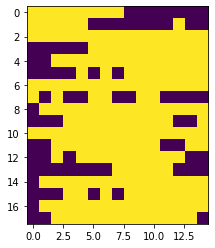

In [102]:
choicearr = split_by_trials(choices, blens, chop='max')[:,:15]
choicearr[1::2,:] *= -1
choicearr = (choicearr + 1) / 2

choicearr[np.isnan(choicearr)] = 0
choicearr[choicearr == 0.5] = 1

plt.imshow(choicearr)

  0%|          | 0/5000 [00:00<?, ?it/s]

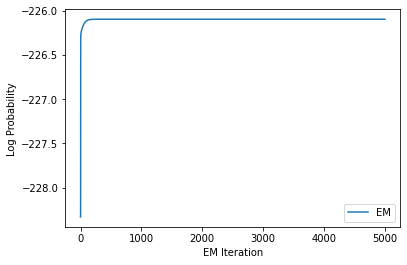

In [94]:
obs = choicearr # Treat observations generated above as synthetic data.


N_iters = 5000
obs_dim = obs.shape[1]

## testing the constrained transitions class
hmm = ssm.HMM(num_states, obs_dim, observations="block")

hmm_lls = hmm.fit(obs, method="em", num_iters=N_iters, init_method="kmeans")
,
plt.plot(hmm_lls, label="EM")
# plt.plot([0, N_iters], true_ll * np.ones(2), ':k', label="True")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")
plt.show()

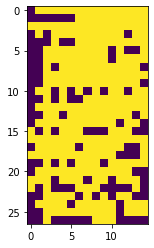

In [91]:
plt.imshow(obs)

In [98]:
hmm.observations.params

(array([[0.68887108],
        [5.78412678],
        [0.        ]]),
 array([[ 4.2302302 ],
        [ 4.98481873],
        [13.20968875]]))

In [96]:
probs=  hmm.observations.log_likelihoods(obs, None, None, None)
zstates = hmm.most_likely_states(obs)

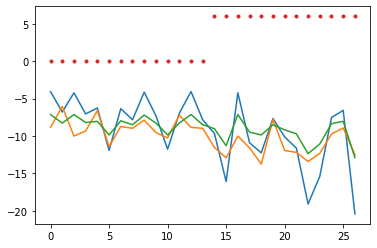

In [97]:
plt.plot(probs)
plt.plot(zstates * 3, '.')

In [99]:
zstates

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2])